This project explores macroeconomic indicators to understand when it may be a good time to buy gold. We collected and cleaned data from six sources including Gold prices, CPI, Crude Oil, Fed Funds Rate, S&P 500, and the USD Index. We aimed to prepare a clean, merged monthly dataset suitable for analysis. 

In [ ]:
import pandas as pd

We used a function called 'load_and_prepare()' to standardize the loading and cleaning of multiple macroeconomic datasets. This helps ensure consistency across all datasets.

In [14]:
def load_and_prepare(filepath, date_col, value_col=None, date_format=None, resample=True, rename_to=None, sep=','):
    """
    Loads and cleans a time series dataset.

    Parameters:
    - filepath (str): Path to the CSV file.
    - date_col (str): Column name for dates.
    - value_col (str): Column name for the numeric value to process (e.g. 'Close').
    - date_format (str): Optional date parsing format (e.g. '%Y-%m-%d').
    - resample (bool): If True, resamples daily data to monthly average.
    - rename_to (str): New column name for the value_col (e.g. 'Gold_Price').
    - sep (str): Delimiter used in the CSV file. Default is ','.

    Returns:
    - A cleaned pandas DataFrame with 'Date' and one or more columns.
    """
    import pandas as pd

    # Load file
    df = pd.read_csv(filepath, sep=sep, header=0)
    df.columns = df.columns.str.strip()  # remove trailing spaces

    # Parse date column
    df[date_col] = pd.to_datetime(df[date_col], format=date_format)

    # Process numeric column
    if value_col:
        if df[value_col].dtype == 'object':
            # Remove commas and convert to float
            df[value_col] = df[value_col].str.replace(',', '', regex=False).astype(float)
        else:
            df[value_col] = pd.to_numeric(df[value_col], errors='coerce')

        df = df[df[value_col].notna()]  # Drop rows where value is NaN

        # Resample to monthly average if needed
        if resample:
            df = df.set_index(date_col)[value_col].resample('M').mean().reset_index()
        else:
            df = df[[date_col, value_col]]

        # Rename value column if requested
        if rename_to:
            df.rename(columns={value_col: rename_to}, inplace=True)
    else:
        df = df.set_index(date_col).resample('M').mean().reset_index()

    # Standardize date column
    df.rename(columns={df.columns[0]: 'Date'}, inplace=True)
    df['Date'] = df['Date'].dt.to_period('M').dt.to_timestamp()

    return df

In [15]:
# Load and process all datasets using the function

monthly_gold = load_and_prepare(
    filepath='data/raw/XAU Daily Data (2004-2025).csv',
    date_col='Date',
    value_col='Close',
    date_format='%Y.%m.%d %H:%M',
    rename_to='Gold_Price',
    sep=';'
)

monthly_oil = load_and_prepare(
    filepath='data/raw/Crude Oil Price Historical Data.csv',
    date_col='observation_date',
    value_col='DCOILWTICO',
    rename_to='Oil_Price'
)

monthly_usd = load_and_prepare(
    filepath='data/raw/USD Index.csv',
    date_col='Date',
    value_col='Value',
    date_format='%m/%d/%Y',
    rename_to='USD_Index'
)

monthly_sp500 = load_and_prepare(
    filepath='data/raw/S&P 500 Historical Data.csv',
    date_col='Date',
    value_col='Price',
    date_format='%m/%d/%Y',
    rename_to='SP500_Price'
)

# For CPI and Fed Funds, we just rename and format dates (already monthly)
cpi = pd.read_csv('data/raw/CPI_Monthly.csv')
cpi.rename(columns={'observation_date': 'Date', 'CPIAUCNS': 'CPI'}, inplace=True)
cpi['Date'] = pd.to_datetime(cpi['Date']).dt.to_period('M').dt.to_timestamp()

fed = pd.read_csv('data/raw/Federal Funds Effective Rate.csv')
fed.rename(columns={'observation_date': 'Date', 'FEDFUNDS': 'FedFunds'}, inplace=True)
fed['Date'] = pd.to_datetime(fed['Date']).dt.to_period('M').dt.to_timestamp()

/var/folders/4m/mxrrfqc14z9gp90g94z9_4qh0000gn/T/ipykernel_10068/1512598948.py:38: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df = df.set_index(date_col)[value_col].resample('M').mean().reset_index()
/var/folders/4m/mxrrfqc14z9gp90g94z9_4qh0000gn/T/ipykernel_10068/1512598948.py:38: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df = df.set_index(date_col)[value_col].resample('M').mean().reset_index()
/var/folders/4m/mxrrfqc14z9gp90g94z9_4qh0000gn/T/ipykernel_10068/1512598948.py:38: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df = df.set_index(date_col)[value_col].resample('M').mean().reset_index()
/var/folders/4m/mxrrfqc14z9gp90g94z9_4qh0000gn/T/ipykernel_10068/1512598948.py:38: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df = df.set_index(date_col)[value_col].res

We merge all cleaned datasets into a single 'master_df' on the 'Date' column. We used left joins to preserve gold as the base. 

In [27]:
# Merge all dataframes
master_df = monthly_gold.merge(cpi, on='Date', how='left') \
                        .merge(monthly_oil, on='Date', how='left') \
                        .merge(fed, on='Date', how='left') \
                        .merge(monthly_sp500, on='Date', how='left') \
                        .merge(monthly_usd, on='Date', how='left')

Each dataset started and ended on different dates. To ensure accurate merging and comparison, we compute the overlapping date range shared by all datasets and trim the master_df accordingly. 

In [17]:
START_DATE = max(df['Date'].min() for df in [monthly_gold, monthly_oil, monthly_usd, monthly_sp500, cpi, fed])
END_DATE = min(df['Date'].max() for df in [monthly_gold, monthly_oil, monthly_usd, monthly_sp500, cpi, fed])

master_df = master_df[(master_df['Date'] >= START_DATE) & (master_df['Date'] <= END_DATE)]

print(master_df['Date'].min(), "→", master_df['Date'].max())
print(master_df.isna().sum())

2006-01-01 00:00:00 → 2024-04-01 00:00:00
Date           0
Gold_Price     0
CPI            0
Oil_Price      0
FedFunds       0
SP500_Price    0
USD_Index      0
dtype: int64


In [28]:
# View first 10 rows of master_df
master_df.head(10)

,Date,Gold_Price,CPI,Oil_Price,FedFunds,SP500_Price,USD_Index
0,2004-06-01,392.185714,189.7,38.025238,1.03,1132.752381,NaN
1,2004-07-01,397.638095,189.4,40.778095,1.26,1105.838095,NaN
2,2004-08-01,401.063636,189.5,44.903182,1.43,1088.931818,NaN
3,2004-09-01,405.700000,189.9,45.935714,1.61,1117.657143,NaN
4,2004-10-01,420.695238,190.9,53.280476,1.76,1118.066667,NaN
5,2004-11-01,438.747619,191.0,48.469000,1.93,1168.933333,NaN
6,2004-12-01,441.535000,190.3,43.149524,2.16,1199.209091,NaN
7,2005-01-01,423.733333,190.7,46.837000,2.28,1181.410000,NaN
8,2005-02-01,423.563158,191.8,48.148947,2.50,1199.626316,NaN
9,2005-03-01,433.513636,193.3,54.186818,2.63,1194.900000,NaN


All variables in our dataset are numerical or time-based, therefore no categorical variable analysis is needed. 

We check for NaNs, duplicate rows.

In [19]:
# Check for NaNs
master_df.isna().sum()

Date           0
Gold_Price     0
CPI            0
Oil_Price      0
FedFunds       0
SP500_Price    0
USD_Index      0
dtype: int64

In [20]:
# Check for Duplicate Rows
duplicates = master_df.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

Number of duplicate rows: 0


In [21]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 220 entries, 19 to 238
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         220 non-null    datetime64[ns]
 1   Gold_Price   220 non-null    float64       
 2   CPI          220 non-null    float64       
 3   Oil_Price    220 non-null    float64       
 4   FedFunds     220 non-null    float64       
 5   SP500_Price  220 non-null    float64       
 6   USD_Index    220 non-null    float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 13.8 KB


In [22]:
master_df.describe()

,Date,Gold_Price,CPI,Oil_Price,FedFunds,SP500_Price,USD_Index
count,220,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000
mean,2015-02-15 01:31:38.181818112,1344.343628,242.226514,72.538860,1.480545,2297.848432,104.520967
min,2006-01-01 00:00:00,549.033333,198.300000,16.547619,0.050000,757.118182,86.317805
25%,2010-07-24 06:00:00,1129.773335,218.798000,54.917530,0.110000,1341.267641,93.454465
50%,2015-02-15 00:00:00,1297.089048,237.384500,71.679004,0.335000,2023.381818,105.287527
75%,2019-09-08 12:00:00,1682.224193,256.561250,89.234125,2.292500,2907.746429,115.004146
max,2024-04-01 00:00:00,2333.939091,313.548000,133.880000,5.330000,5198.291111,127.482765
std,NaN,395.990615,28.732554,21.958506,1.875806,1146.873478,11.666784


We visualized the monthly average of gold prices to observe long-term trends and volatility. The chart helps reveal any inflation-driven or macroeconomic shifts over time. 

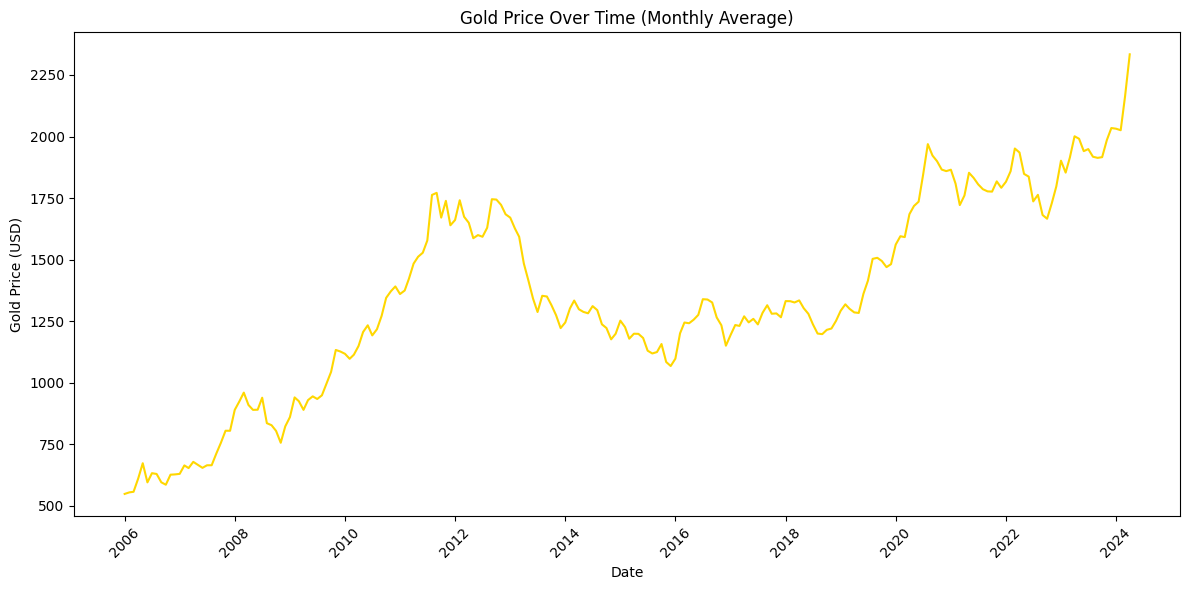

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

# Gold price trend
plt.figure(figsize=(12, 6))
sns.lineplot(data=master_df, x='Date', y='Gold_Price', color='gold')
plt.title('Gold Price Over Time (Monthly Average)')
plt.xlabel('Date')
plt.ylabel('Gold Price (USD)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

This heatmaps shows the correlation between gold and macroeconomic indicators. Notably: 
- Gold price with CPI (0.82)
- Gold and S&P 500 (0.72)
- Negative relationship with Fed Funds rate (-0.21)
- USD Index with Gold (0.49)

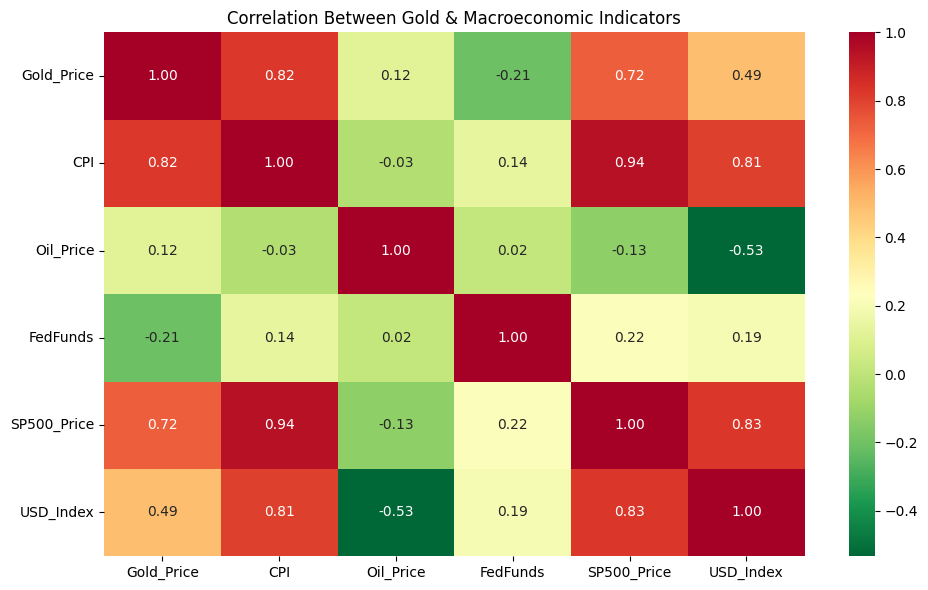

In [26]:
# Correlation heatmap of macro indicators
plt.figure(figsize=(10, 6))
sns.heatmap(master_df.drop(columns='Date').corr(), annot=True, cmap='RdYlGn_r', fmt=".2f")
plt.title('Correlation Between Gold & Macroeconomic Indicators')
plt.tight_layout()
plt.show()